In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

DATA_PATH = '/Users/mpekey/Desktop/FlyVideo/Peak_Signal_Data'

In [7]:
filename = os.path.join(DATA_PATH, 'bouts_dict.pkl')
with open(filename, 'rb') as f:
    bouts_dict = pickle.load(f)

# Inspect the dictionary structure
print(bouts_dict.keys())  # Print the experiment keys

dict_keys(['Fly08022022_6d_SD_B', 'Fly05272022_SD_5d', 'Fly07212022_6d_SD_A', 'Fly06252022_5d_SD_A', 'Fly06262022_5d_SD_A', 'Fly07122022_5d_SD_A', 'Fly06202022_5d', 'Fly07222022_6d_SD_B', 'Fly07132022_5d_SD_B', 'Fly06232022_5d_B_SD', 'Fly06212022_5d', 'Fly07192022_5d_SD_B', 'Fly05252022_SD_5d', 'Fly07222022_6d_SD_A', 'Fly06232022_5d_A_SD', 'Fly07052022_5d_SD_A', 'Fly05182022_5d', 'Fly07062022_5d_SD_B', 'Fly07132022_5d_SD_A', 'Fly06082022_5d', 'Fly07062022_5d_A', 'Fly05222022_5d', 'Fly06302022_5d_SD_A', 'Fly06232022_4d_B', 'Fly07262022_6d_SD_A', 'Fly06242022_5d_SD_B', 'Fly06142022_SD_5d', 'Fly06242022_5_SD_A', 'Fly07142022_5d_SD_A', 'Fly07182022_7d_SD_A', 'Fly07202022_6d_SD_B', 'Fly06252022_5d_SD_B', 'Fly08022022_6d_B', 'Fly06182022_4d', 'Fly08032022_6d_SD_B', 'Fly07052022_5d_A', 'Fly06292022_5d_A', 'Fly06292022_5d_B', 'Fly07082022_5d_B', 'Fly07062022_5d_SD_A', 'Fly07112022_5d_A', 'Fly06272022_5d_SD_A', 'Fly07252022_6d_A', 'Fly08032022_6d_B', 'Fly06282022_5d_SD_B', 'Fly07282022_6d_SD_B'

In [8]:
FEATURES = ['pose.prob_x','pose.prob_y','pose.halt_x','pose.halt_y',
            'pose.thor_post_x','pose.thor_post_y','distance.origin-halt',
            'distance.origin-prob','distance.origin-thor_post','distance.head-prob',
            'distance.thor_post-halt','distance.avg(thor_post-joint1,thor_post-joint2,thor_post-joint3)',
            'distance.avg(origin-joint1,origin-joint2,origin-joint3)']

experiment_features = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

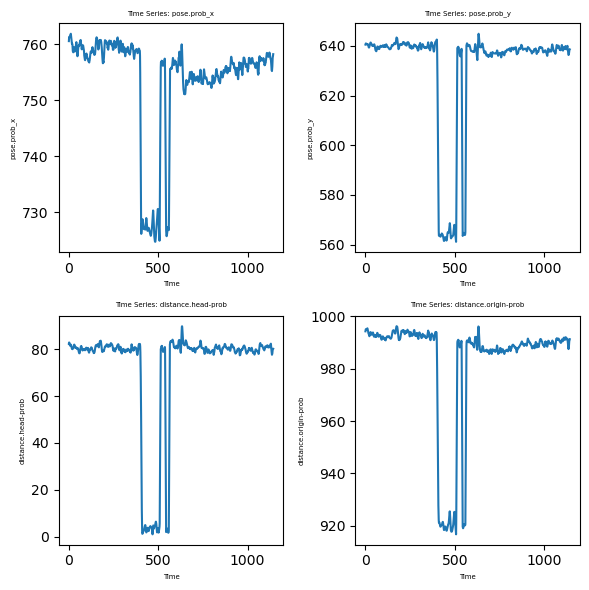

In [6]:
import matplotlib.pyplot as plt

# Define the subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))

# Retrieve the time series data
time_series_names = ['pose.prob_x', 'pose.prob_y', 'distance.head-prob', 'distance.origin-prob']

# Plot each time series in the corresponding subplot
for i, name in enumerate(time_series_names):
    # Retrieve the time series data
    time_series_data = bouts_dict['Fly05182022_5d'][name][1]

    # Create the x-axis values
    time = range(len(time_series_data))

    # Determine the subplot coordinates
    row = i // 2
    col = i % 2

    # Plot the time series in the corresponding subplot
    axs[row, col].plot(time, time_series_data)
    axs[row, col].set_xlabel('Time', fontdict={'fontsize': 5})
    axs[row, col].set_ylabel(name, fontdict={'fontsize': 5})
    axs[row, col].set_title(f'Time Series: {name}', fontdict={'fontsize': 5})

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [4]:
def thresholding_algo(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [14]:
def thresholding_algo_median(y, lag, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    medianFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    medianFilter[lag - 1] = np.median(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1])/stdFilter [i-1] > medianFilter[i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
            medianFilter[i] = np.median(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
            medianFilter[i] = np.median(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter),
                medianFilter = np.asarray(medianFilter))

In [15]:
def thresholding_algo_iqr(y, lag, influence):
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    iqrFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    iqrFilter[lag - 1] = np.percentile(y[0:lag], 75) - np.percentile(y[0:lag], 25)
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1])/stdFilter [i-1] > iqrFilter[i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
            iqrFilter[i] = np.percentile(filteredY[(i-lag+1):i+1], 75) - np.percentile(filteredY[(i-lag+1):i+1], 25)
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
            iqrFilter[i] = np.percentile(filteredY[(i-lag+1):i+1], 75) - np.percentile(filteredY[(i-lag+1):i+1], 25)

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter),
                iqrFilter = np.asarray(iqrFilter))

In [ ]:
median ve interquartile range

In [10]:
def ensemble_weighted(results, weights):
    combined_signals = np.zeros(len(results[0]['signals']))

    for i, result in enumerate(results):
        # Accumulate the signals with weights
        combined_signals += weights[i] * result['signals']

    # Apply threshold to determine the final peak detection result
    #final_signals = (combined_signals >= np.sum(weights) / 2).astype(int)
    final_signals = np.where(np.abs(combined_signals) > np.abs(np.sum(weights) / 2),
                             np.where(combined_signals > 0, 1, -1),
                             0)

    return final_signals

In [11]:
def predict_peaks(lag=100, threshold=3, influence=0.01, selected_features=None, selected_weights=None):
    if selected_features is not None and selected_weights is not None and len(selected_features)==len(selected_weights):
        features = selected_features
    else:
        features = experiment_features

    peak_predictions = {}

    for fly in bouts_dict.keys():
        fly_experiments = bouts_dict[fly]
        for experiment in range(fly_experiments.shape[0]):
            fly_ts = fly_experiments.loc[experiment,:]
            
            results = []
            for feature in features:
                y = fly_ts[feature]
                result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)
                results.append(result)
            combined_results = ensemble_weighted(results, selected_weights)
            peak_dots_x = np.where((combined_results == 1) | (combined_results == -1))[0]
            peak_predictions[f'{fly}_id_{experiment}'] = peak_dots_x
    return peak_predictions


def plot_peaks(peaks, fly_name, experiment_id, feature):
    plot_data = bouts_dict[fly_name].iloc[experiment_id,:][feature]
    peak_dots_y = plot_data[peaks[f'{fly_name}_id_{experiment_id}']]
    plt.plot(plot_data)
    plt.scatter(x = peaks[f'{fly_name}_id_{experiment_id}'], y = peak_dots_y, c = 'red', marker='o', label='Peaks', s=8)
    plt.show()

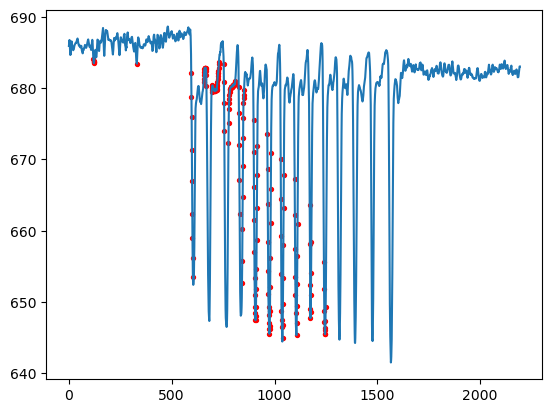

In [12]:
weights = [0.4 if i == 'distance.origin-prob' else 0.6/(len(experiment_features)-1) for i in experiment_features]
deneme = {}
for fly in ['Fly06252022_5d_SD_A']:
    fly_experiments = bouts_dict[fly]
    for experiment in [2]:
        fly_ts = fly_experiments.loc[experiment,:]
        
        results = []
        for feature in experiment_features:
            y = fly_ts[feature]
            result = thresholding_algo(y, lag=100, threshold=3.5, influence=0.001)
            results.append(result)
        combined_results = ensemble_weighted(results, weights)
        peak_dots_x = np.where((combined_results == 1) | (combined_results == -1))[0]
        deneme[f'{fly}_id_{experiment}'] = peak_dots_x

plot_peaks(deneme, 'Fly06252022_5d_SD_A', 2, 'distance.origin-prob')

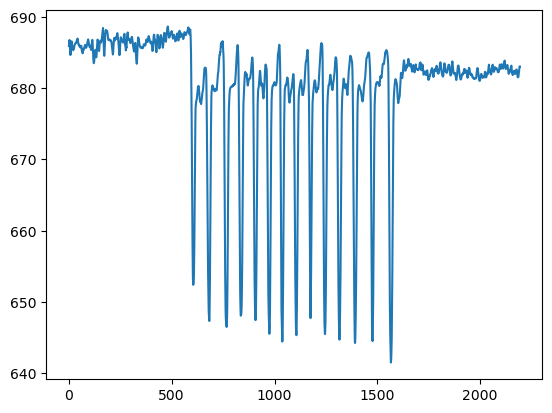

In [16]:
weights = [0.4 if i == 'distance.origin-prob' else 0.6/(len(experiment_features)-1) for i in experiment_features]
deneme = {}
for fly in ['Fly06252022_5d_SD_A']:
    fly_experiments = bouts_dict[fly]
    for experiment in [2]:
        fly_ts = fly_experiments.loc[experiment,:]
        
        results = []
        for feature in experiment_features:
            y = fly_ts[feature]
            result = thresholding_algo_median(y, lag=100, influence=0.001)
            results.append(result)
        combined_results = ensemble_weighted(results, weights)
        peak_dots_x = np.where((combined_results == 1) | (combined_results == -1))[0]
        deneme[f'{fly}_id_{experiment}'] = peak_dots_x

plot_peaks(deneme, 'Fly06252022_5d_SD_A', 2, 'distance.origin-prob')

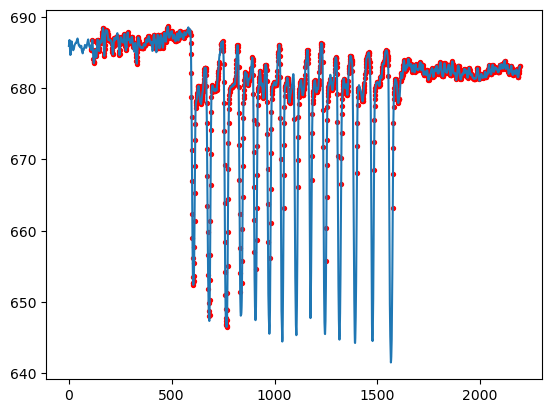

In [17]:
weights = [0.4 if i == 'distance.origin-prob' else 0.6/(len(experiment_features)-1) for i in experiment_features]
deneme = {}
for fly in ['Fly06252022_5d_SD_A']:
    fly_experiments = bouts_dict[fly]
    for experiment in [2]:
        fly_ts = fly_experiments.loc[experiment,:]
        
        results = []
        for feature in experiment_features:
            y = fly_ts[feature]
            result = thresholding_algo_iqr(y, lag=100, influence=0.001)
            results.append(result)
        combined_results = ensemble_weighted(results, weights)
        peak_dots_x = np.where((combined_results == 1) | (combined_results == -1))[0]
        deneme[f'{fly}_id_{experiment}'] = peak_dots_x

plot_peaks(deneme, 'Fly06252022_5d_SD_A', 2, 'distance.origin-prob')

In [13]:
weights = [0.5 if i == 'distance.origin-prob' else 0.5/(len(FEATURES)-1) for i in FEATURES]
peak_predictions = predict_peaks(lag=100, threshold=3, influence=0.01,
                                 selected_weights = weights)

In [16]:
with open('peak_predictions_weighted_z.pkl', 'wb') as f:
    pickle.dump(peak_predictions, f)

In [ ]:
with open('peak_predictions_weighted_z.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)